In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [93]:
my_team = ['Carroll', 'James', 'Valanciunas', 'Oubre']
other_team = ['Love', 'Harris', 'DeRozan', 'Vucevic']
both_teams = my_team + other_team

In [94]:
#load in all the data
lbj = pd.read_csv("data/lbj.csv")
dc = pd.read_csv("data/dc.csv")
jv = pd.read_csv("data/jv.csv")
ko = pd.read_csv("data/ko.csv")
kl = pd.read_csv("data/kl.csv")
th = pd.read_csv("data/th.csv")
dd = pd.read_csv("data/dd.csv")
nv = pd.read_csv("data/nv.csv")
lst_data = [lbj, dc, jv, ko, kl, th, dd, nv,]

In [95]:
#the columns in the dataset
lbj.columns

Index(['PLAYER', 'TEAM', 'DATE', 'MATCHUP', 'W/L', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-'],
      dtype='object')

In [138]:
#concatenate all the data into a single DataFrame
complete_data = pd.concat(lst_data, ignore_index=True)

In [139]:
#the dataset comes with padding rows for future games, so we drop those as they're full of NaN values
complete_data = complete_data.dropna(axis=0, how='any')
shape = complete_data.shape
shape

(222, 25)

In [195]:
#data cleaning funcitons
def clean_player_name(row):
    name = row.PLAYER
    start_index = 0
    end_index = 0
    for i in range(len(name)):
        if name[i] == "<":
            start_index = i
        elif name[i] == ">":
            end_index = i + 1
    return name[:start_index] + name[end_index:]


def double_double(row):
    return int(np.count_nonzero(np.array([row.PTS, row.AST, row.REB]) >= 10) >= 2)

def triple_double(row):
    return int(np.count_nonzero(np.array([row.PTS, row.AST, row.REB]) >= 10) >= 3)

def fantasy_points(row):
    return row.FGMI * -0.5 + row.FTMI * -0.5 + row['3PM'] * 1 + row.REB * 1 + row.AST * 1.5 + row.STL * 3 + row.BLK * 3 + row.TOV * -1 + row.DD * 5 + row.TD * 10 + row.PTS * 1   

In [196]:
#clean the player name data so it's easier to search for individual players
complete_data.PLAYER = complete_data.apply(clean_player_name, axis=1)

In [197]:
complete_data.columns

Index(['PLAYER', 'TEAM', 'DATE', 'MATCHUP', 'W/L', 'MIN', 'PTS', 'FGM', 'FGA',
       'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB',
       'AST', 'STL', 'BLK', 'TOV', 'PF', '+/-'],
      dtype='object')

In [198]:
complete_data.shape

(222, 25)

In [199]:
#we need a few more columns to analyze fantasy points so i'll add them here
relevant_data = complete_data[['PLAYER', 'PTS', 'AST', 'REB', 'STL', 'TOV', 'BLK', '3PM']]
relevant_data['FGMI'] = complete_data['FGA'] - complete_data['FGM']
relevant_data['FTMI'] = complete_data['FTA'] - complete_data['FTM']
relevant_data['DD'] = relevant_data.apply(double_double, axis=1)
relevant_data['TD'] = relevant_data.apply(triple_double, axis=1)
relevant_data['FPS'] = relevant_data.apply(fantasy_points, axis=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A 

In [215]:
#here we define two functions to sample a test statistic for each team
#we will combine these test statistics to be a difference in points
def team_stat(team):
    #first we want to sample a random set of fantasy points
    total = 0
    for name in team:
        name_data = relevant_data.loc[relevant_data.PLAYER.str.contains(name)] #filtered by name
        total += name_data.sample().FPS.item()
    return total


In [218]:
results = []
for i in range(10000):
    mine = team_stat(my_team)
    theirs = team_stat(other_team)
    results += [theirs - mine]


In [221]:
results = np.array(results)

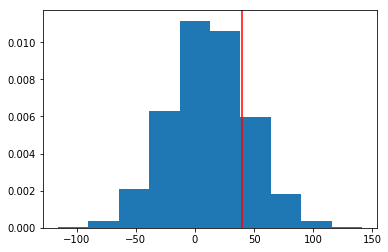

In [236]:
plt.hist(results, normed=True)
plt.axvline(x=40, color='red')
plt.show()

In [227]:
chance = 1 - np.count_nonzero(results >= 40) / 10000

In [229]:
print("You have a {0}% chance of winning".format(chance * 100))

You have a 80.01% chance of winning


In [244]:
#now construct a confidence interval
chances = []
for i in range(100):
    results = []
    for j in range(1000):
        mine = team_stat(my_team)
        theirs = team_stat(other_team)
        results += [theirs - mine]
    results = np.array(results)
    chances += [1 - np.count_nonzero(results >= 40) / 1000]

chances = np.array(chances)

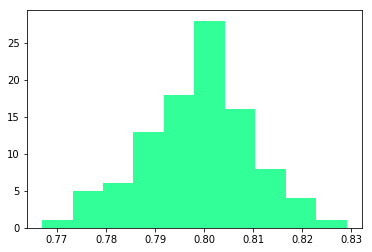

95% Confidence Interval: [0.77700, 0.77700]


In [249]:
lower = np.percentile(chances, 2.5)
upper = np.percentile(chances, 97.5)
plt.hist(chances, color="#33FF99")
plt.show()
print("95% Confidence Interval: [{0:.5f}, {0:.5f}]".format(lower, upper))